In [74]:
#import csv
#from dbfread import DBF 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
#dbf_file = DBF('OD 2017/OD_2017_v1.dbf')

'''with open('OD_2017_original.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(dbf_file.field_names)
    for record in dbf_file:
        writer.writerow(list(record.values()))'''

"with open('OD_2017_original.csv', 'w', newline='') as csvfile:\n    writer = csv.writer(csvfile)\n    writer.writerow(dbf_file.field_names)\n    for record in dbf_file:\n        writer.writerow(list(record.values()))"

In [76]:

def cria_emissoes_kg_co2_km(x):
    if x <= 3:
        return 3.16
    elif 3 < x <= 8:
        return 1.28
    elif 8 < x <= 12:
        return 0.19
    elif 12 < x <= 14:
        return 0.07
    else:
        return 0
    
def cria_emissoes_kg_co2_km_pass(x):
    if x <= 3:
        return 0.0035
    elif 3 < x <= 8:
        return 0.0160
    elif 8 < x <= 12:
        return 0.1268
    elif 12 < x <= 14:
        return 0.0711
    else:
        return 0

def categoriza_modo_principal(x):
    if x <= 3:
        return "metrô, trem ou monotrilho"
    elif 3 < x <= 8:
        return "ônibus ou van"
    elif 8 < x <= 12:
        return "automovel"
    elif 12 < x <= 14:
        return "moto"
    else:
        return "bicileta ou a pé"

def cria_emissao_co2_total(dataframe, referencia, fator_expansao='FE_VIA', distancia='DISTANCIA'):
    return dataframe[referencia]*dataframe[fator_expansao]*dataframe[distancia]

def remove_percentil(dataframe, column, percentile=0.95):
    percentil = dataframe[column].quantile(percentile)
    return dataframe[dataframe[column] <= percentil]


In [78]:
base = pd.read_csv('OD_2017_original.csv')

In [79]:
#A base original possui apenas variáveis numéricas dos tipos int e float. Algumas dessas variáveis numéricas são códigos descritos na documentação
base.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183092 entries, 0 to 183091
Data columns (total 128 columns):
 #    Column      Dtype  
---   ------      -----  
 0    ZONA        int64  
 1    MUNI_DOM    int64  
 2    CO_DOM_X    int64  
 3    CO_DOM_Y    int64  
 4    ID_DOM      int64  
 5    F_DOM       int64  
 6    FE_DOM      float64
 7    DOM         int64  
 8    CD_ENTRE    int64  
 9    DATA        int64  
 10   TIPO_DOM    int64  
 11   AGUA        int64  
 12   RUA_PAVI    int64  
 13   NO_MORAD    int64  
 14   TOT_FAM     int64  
 15   ID_FAM      int64  
 16   F_FAM       int64  
 17   FE_FAM      float64
 18   FAMILIA     int64  
 19   NO_MORAF    int64  
 20   CONDMORA    int64  
 21   QT_BANHO    float64
 22   QT_EMPRE    float64
 23   QT_AUTO     float64
 24   QT_MICRO    float64
 25   QT_LAVALOU  float64
 26   QT_GEL1     float64
 27   QT_GEL2     float64
 28   QT_FREEZ    float64
 29   QT_MLAVA    float64
 30   QT_DVD      float64
 31   QT_MICROON  float64
 32 

<>Removendo colunas desinteressantes para o trabalho<>
<>Os detalhes sobre cada coluna estão disponíveis no arquivo LAYOUT OD2017_v1.xlsx<>

In [80]:
colunas_removidas = ['ID_DOM', 'F_DOM', 'DOM', 'CD_ENTRE', 'DATA', 'AGUA', 'RUA_PAVI', 'ID_FAM', 'F_FAM', 'QT_BANHO', 'QT_EMPRE',
                     'QT_MICRO', 'QT_LAVALOU', 'QT_GEL1', 'QT_GEL2', 'QT_FREEZ', 'QT_MLAVA', 'QT_DVD', 'QT_MICROON', 'QT_SECAROU',
                     'NAO_DCL_IT', 'PONTO_BR', 'CD_RENFA', 'ID_PESS', 'F_PESS', 'PESSOA', 'MUNIESC', 'VINC1', 'VINC2',
                     'DIA_SEM', 'PAG_VIAG', 'TP_ESAUTO', 'VL_EST', 'VIA_BICI', 'TP_ESBICI']


colunas_categoricas = ['ZONA', 'MUNI_DOM', 'TIPO_DOM', 'CONDMORA', 'CRITERIOBR', 'SIT_FAM', 'SEXO', 'ESTUDA', 'GRAU_INS', 'CD_ATIVI', 'CO_REN_I', 'TRAB1_RE', 'TRABEXT1', 'OCUP1',
                       'SETOR1', 'MUNITRA1', 'MUNITRA2', 'TRAB2_RE', 'TRABEXT2', 'OCUP2', 'SETOR2', 'ZONA_O', 'MUNI_O', 'ZONA_D', 'MUNI_D', 'ZONA_T1', 'MUNI_T1', 'ZONA_T2', 'MUNI_T2', 'ZONA_T3',
                       'MUNI_T3', 'MOTIVO_O', 'MOTIVO_D', 'MOT_SRES', 'SERVIR_O', 'SERVIR_D', 'MODO1', 'MODO2', 'MODO3', 'MODO4', 'MODOPRIN', 'TIPVG', 'PE_BICI']

df = base.drop(colunas_removidas, axis=1)
df[colunas_categoricas] = df[colunas_categoricas].astype('category'); 

In [81]:
#Removendo colunas com muitos valores nulos
col_nulos = ['ANO_AUTO2', 'ANO_AUTO3', 'ZONA_ESC', 'CO_ESC_X', 'CO_ESC_Y', 'TIPO_ESC', 'ZONATRA2', 'MUNITRA2', 'CO_TR2_X', 'CO_TR2_Y', 'TRAB2_RE', 'TRABEXT2', 'OCUP2', 'SETOR2',
             'ZONA_T1', 'MUNI_T1', 'CO_T1_X', 'CO_T1_Y', 'ZONA_T2', 'MUNI_T2', 'CO_T2_X', 'CO_T2_Y', 'ZONA_T3', 'MUNI_T3', 'CO_T3_X', 'CO_T3_Y', 'MODO2', 'MODO3', 'MODO4', 'PE_BICI']


df = df.drop(col_nulos, axis=1)

In [82]:
df['ref_emissoes_kg_co2_km'] = df['MODOPRIN'].apply(cria_emissoes_kg_co2_km)
df['ref_emissoes_kg_co2_km_pass'] = df['MODOPRIN'].apply(cria_emissoes_kg_co2_km_pass)
df['total_emissoes_kg_co2'] = cria_emissao_co2_total(dataframe=df, referencia='ref_emissoes_kg_co2_km')
df['total_emissoes_kg_co2_pass'] = cria_emissao_co2_total(dataframe=df, referencia='ref_emissoes_kg_co2_km_pass')
df['MODOPRIN'] = df['MODOPRIN'].apply(categoriza_modo_principal)

In [83]:
df.to_csv('OD_2017_Trabalhada.csv')

In [18]:
df_modos = df.groupby('MODOPRIN').sum()
df_modos = df_modos.drop(df_modos[df_modos.index=='bicileta ou a pé'].index)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_9868\855710266.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_modos = df.groupby('MODOPRIN').sum()


Text(0.5, 1.1, 'Percentual de emissão de CO2 equivalente por modo de transporte')

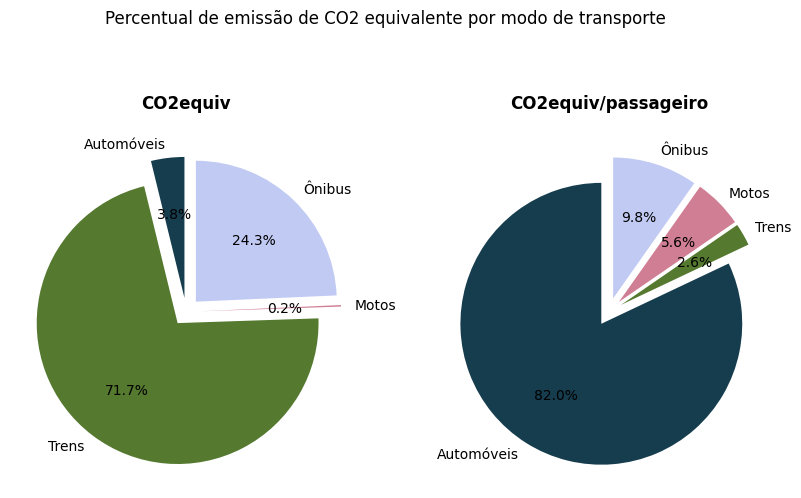

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

labels =['Automóveis', 'Trens', 'Motos', 'Ônibus']

total = df_modos['total_emissoes_kg_co2'].sum()
axes[0].pie(df_modos['total_emissoes_kg_co2'], labels=labels, autopct='%1.1f%%', explode=[0.1, 0.1, 0.1, 0.1], startangle=90, colors=sns.color_palette('cubehelix', n_colors=4))
axes[1].pie(df_modos['total_emissoes_kg_co2_pass'], labels=labels, autopct='%1.1f%%', explode=[0.1, 0.1, 0.1, 0.1], startangle=90, colors=sns.color_palette('cubehelix', n_colors=4))



axes[0].set_title('CO2equiv', y=1.055, fontweight='bold')
axes[1].set_title('CO2equiv/passageiro', y=1.055, fontweight='bold')
fig.suptitle('Percentual de emissão de CO2 equivalente por modo de transporte', y=1.1)


In [21]:
df_modos = df.groupby('MODOPRIN',  as_index=False).mean()
df_modos = df_modos.drop(df_modos[df_modos['MODOPRIN']=='bicileta ou a pé'].index)

C:\Users\Pichau\AppData\Local\Temp\ipykernel_9868\3522663881.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_modos2 = df.groupby('MODOPRIN',  as_index=False).mean()


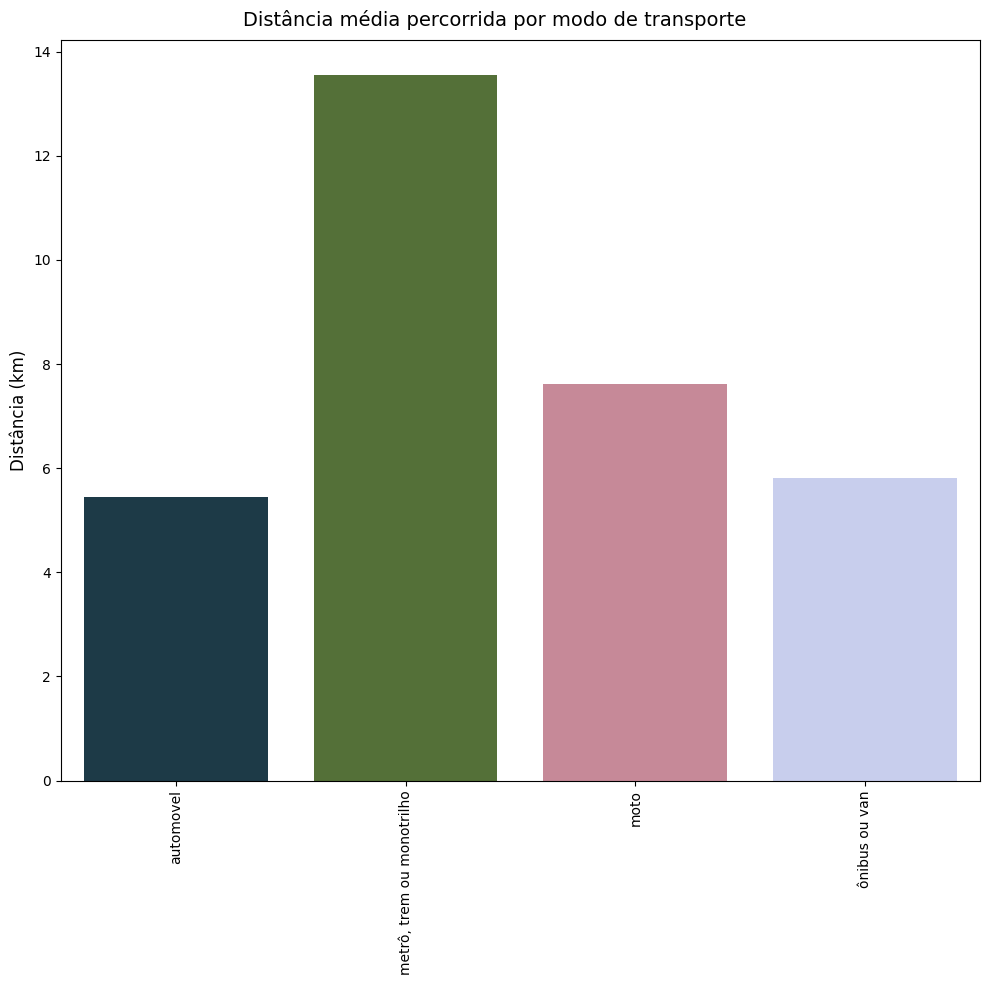

In [66]:
fig = plt.figure(figsize=(10,10))
sns.barplot(x=df_modos['MODOPRIN'], y=df_modos['DISTANCIA']/1000, palette='cubehelix')

fig.suptitle('Distância média percorrida por modo de transporte', fontsize=14)
plt.ylabel('Distância (km)', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

(0.0, 4000.0)

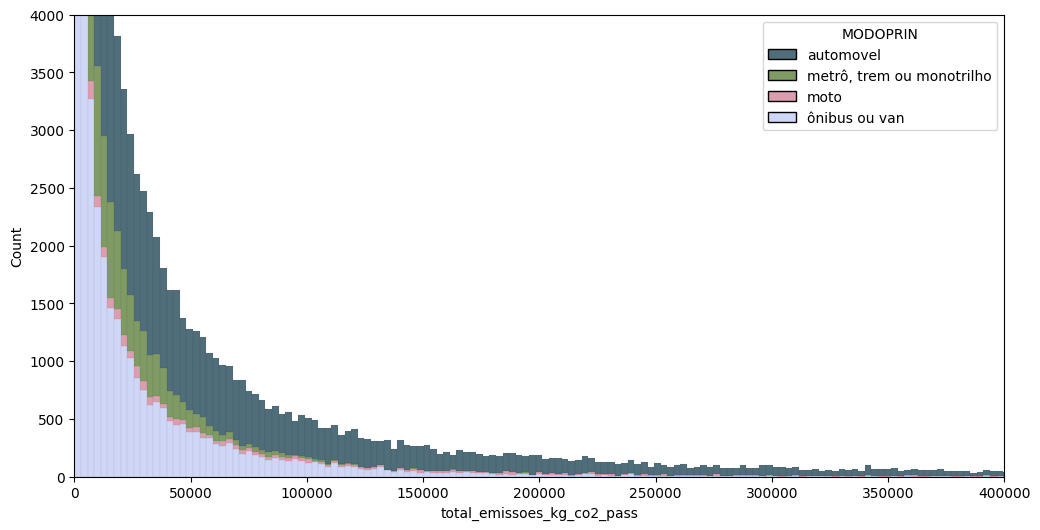

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))
df_filtrada = df.drop(df[df['MODOPRIN']=='bicileta ou a pé'].index)


sns.histplot(x='total_emissoes_kg_co2_pass', hue='MODOPRIN', data=df_filtrada, palette='cubehelix', multiple='stack', hue_order=['automovel', 'metrô, trem ou monotrilho', 'moto', 'ônibus ou van'])
ax.set_xlim(0,400000)
ax.set_ylim(0,4000)